In [121]:
from pymongo import MongoClient
from pandas import DataFrame
import regex
from pathlib import Path
from pydash import count_by
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def load_patterns(known_patterns_file):
    with open(known_patterns_file, mode='r') as file:
        return [regex.compile(line.rstrip(), regex.UNICODE) for line in file if line[0] != '#']
known_patterns = load_patterns(Path('./data_type_patterns.txt'))
EMPTY = [
    regex.compile(r''),  # epsilon
    regex.compile(r'null', regex.IGNORECASE),  # null
    regex.compile(r'unknown', regex.IGNORECASE),  # unknown
    regex.compile(r'[?]+', regex.IGNORECASE),  # ???
    regex.compile(r'[-]+', regex.IGNORECASE),  # ---
    regex.compile(r'[*]+', regex.IGNORECASE),  # ***
    regex.compile(r'[#]+', regex.IGNORECASE),  # ###
    regex.compile(r'n/?a', regex.IGNORECASE),  # NA or N/A
    regex.compile(r'nan', regex.IGNORECASE)  # NaN
]
def matches_empty(field: str) -> bool:
    return any(
        compiled_pattern.fullmatch(field)
        for compiled_pattern in EMPTY
    )
def get_known_pattern_match(field):
    if matches_empty(field):
        return -1
    return next(
        (
            i_pattern
            for i_pattern, compiled_pattern in enumerate(known_patterns)
            if compiled_pattern.fullmatch(field)
        ),
        None
    )
def get_values():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['lines'].aggregate([
            {
                '$unwind': {
                    'path': '$post-processed'
                }
            }, {
                '$project': {
                    'value': '$post-processed', 
                    '_id': False
                }
            }
        ])

In [3]:
with Pool() as pool:
    matches = list(tqdm(pool.imap_unordered(
        get_known_pattern_match, 
        (value['value'] for value in get_values()), 
        chunksize=131072
    ), total=104471187))

104471196it [06:18, 276178.88it/s]                               


match counts
```
{'Number': 87797387,
 'Empty': 4366209,
 'Text': 5149154,
 'Unknown': 4131448,
 'Hash': 1380440,
 'Date': 1118010,
 'File path': 32934,
 'Boolean': 139136,
 'Domain name': 63220,
 'Brackets': 156745,
 'E-Mail address': 444,
 'URL': 124107,
 'Percentage': 10845,
 'Currency': 1080,
 'IP address': 37}
 ```

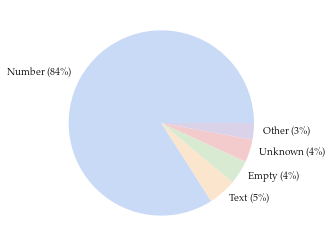

In [139]:
# # data_type_map = {
# #     None: 'Unknown',
# #     -1: 'Empty',
# #     0: 'Boolean',
# #     1: 'Hash',
# #     2: 'Brackets',
# #     3: 'Percentage',
# #     4: 'Currency',
# #     5: 'Text',
# #     6: 'URL',
# #     7: 'Date',
# #     8: 'Domain name',
# #     9: 'E-Mail address',
# #     10: 'IP address',
# #     11: 'File path',
# #     12: 'Number',
# # }
# # match_counts = {
# #     data_type_map[key]: count
# #     for key, count in count_by(matches).items()
# # }
total = sum(match_counts.values())

df1 = DataFrame(
    match_counts.items(), 
    columns=['Data type', 'Count']
).set_index(
    'Data type'
)

df = df1.sort_values(
    by='Count', 
    ascending=False
).nlargest(
    4,
    columns=['Count']
)
df.loc['Other'] = df1.nsmallest(df1.shape[0] - 4, columns=['Count'])['Count'].sum()
df['expanded'] = df.apply(lambda row: row.name + ' (' + str(round(100 * row['Count'] / total)) + '\%)', axis='columns')
df.set_index('expanded', inplace=True)
ax = df.plot(
    kind='pie',
    y='Count',
    legend=False
)

ax.set(
    ylabel=''
)

plt.tight_layout()
ax.get_figure().savefig('data-type-distribution')